prepping the code

In [21]:
from itertools import count
import numpy as np
import pandas as pd
import psycopg2
import dotenv
import os
from matplotlib import animation
from matplotlib import pyplot as plt
from mplsoccer import Pitch
from scipy.interpolate import interp1d

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)


matches_1 = """
SELECT  
    me.*, 
    et.name AS event_name,  
    et.description AS event_description  
FROM public.matchevents me
INNER JOIN public.eventtypes et USING(eventtype_id)
INNER JOIN public.matches m USING(match_id)
WHERE m.match_id = '5pcyhm34h5c948yji4oryevpw'
"""

df_matches = pd.read_sql_query(matches_1,conn)


# Convert timedelta-like format to seconds
# df_matches["timestamp"] = df_matches["timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)
# df_matches["end_timestamp"] = df_matches["end_timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)

# # Check the result
# print(df_matches[["timestamp", "end_timestamp"]].head())


df_matches.head()

,match_id,event_id,eventtype_id,result,success,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,x,y,end_coordinates_x,end_coordinates_y,receiver_player_id,event_name,event_description
0,5pcyhm34h5c948yji4oryevpw,2704102295,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,0 days 00:00:00.087000,0 days 00:00:01.627000,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,6g9x1y7xmjzwhk646v1iyuup5,50.0,50.0,37.0,49.3,cfxzvlgvt9jj17qxq41t9sxcl,PASS,StatsPerform/Opta event type: PASS
1,5pcyhm34h5c948yji4oryevpw,2704102881,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,COMPLETE,True,1,0 days 00:00:01.627000,0 days 00:00:04.178000,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,cfxzvlgvt9jj17qxq41t9sxcl,39.1,48.0,32.3,38.9,2ky2kn7gpjorkyg9zyg68pk6i,PASS,StatsPerform/Opta event type: PASS
2,5pcyhm34h5c948yji4oryevpw,2704102909,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,INCOMPLETE,False,1,0 days 00:00:04.178000,NaT,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,2ky2kn7gpjorkyg9zyg68pk6i,36.3,36.4,69.7,16.7,None,PASS,StatsPerform/Opta event type: PASS
3,5pcyhm34h5c948yji4oryevpw,2704103595,2464af85-9671-4c4c-90ae-100af0a5e2ee,WON,True,1,0 days 00:00:06.575000,NaT,alive,cyrrlv6l1onld5x247w1q1jlr,bw9wm8pqfzcchumhiwdt2w15c,9fvwcsajeousbo5o0e84cj2sp,22.0,91.6,NaN,NaN,None,DUEL,StatsPerform/Opta event type: DUEL
4,5pcyhm34h5c948yji4oryevpw,2704103597,2464af85-9671-4c4c-90ae-100af0a5e2ee,LOST,False,1,0 days 00:00:06.576000,NaT,alive,cyrrlv6l1onld5x247w1q1jlr,cyrrlv6l1onld5x247w1q1jlr,8ozlo6qrdavr86guhclwvh84q,78.0,8.4,NaN,NaN,None,DUEL,StatsPerform/Opta event type: DUEL


testing out the model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Convert categorical features into numeric values (for example, 'event_name')
df_matches['event_name'] = df_matches['event_name'].astype('category').cat.codes
df_matches['event_description'] = df_matches['event_description'].astype('category').cat.codes

# Select your features (X) and target variable (y)
X = df_matches[['event_name', 'event_description', 'x', 'y']]  # Add more features if needed
y = df_matches['event_name']  # Assuming 'match_id' is the target you want to predict

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors based on performance
knn.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       0.00      0.00      0.00         1
           2       0.75      0.82      0.78        11
           3       0.80      0.84      0.82        19
           5       0.33      0.60      0.43         5
           6       0.60      0.30      0.40        10
           8       0.00      0.00      0.00         3
           9       0.50      0.50      0.50         2
          10       0.33      1.00      0.50         1
          11       0.75      0.86      0.80         7
          12       0.00      0.00      0.00         2
          14       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00      0.57      0.73         7
          18       0.75      1.00      0.86         3
          19       0.00      0.00      0.00         5
          20       0.20      0.17      0.18         6
          21       0.90    

In [23]:
from sklearn.model_selection import cross_val_score

# Use cross-validation to find the optimal K value
k_range = range(1, 21)  # Try K values from 1 to 20
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_range[np.argmax(cv_scores)]
print(f"Best K: {best_k}")


Best K: 1


In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Select your features (X) and target variable (y)
X = df_matches[['event_name', 'event_description', 'x', 'y']]  # Add more features if needed
y = df_matches['x']  # Assuming 'goals_scored' is the target you want to predict

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can tune n_neighbors based on performance
knn.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = knn.predict(X_test_scaled)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


Mean Squared Error: 4.261345911949684


C:\Users\lalad\AppData\Local\Temp\ipykernel_20792\3883270101.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_events))


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

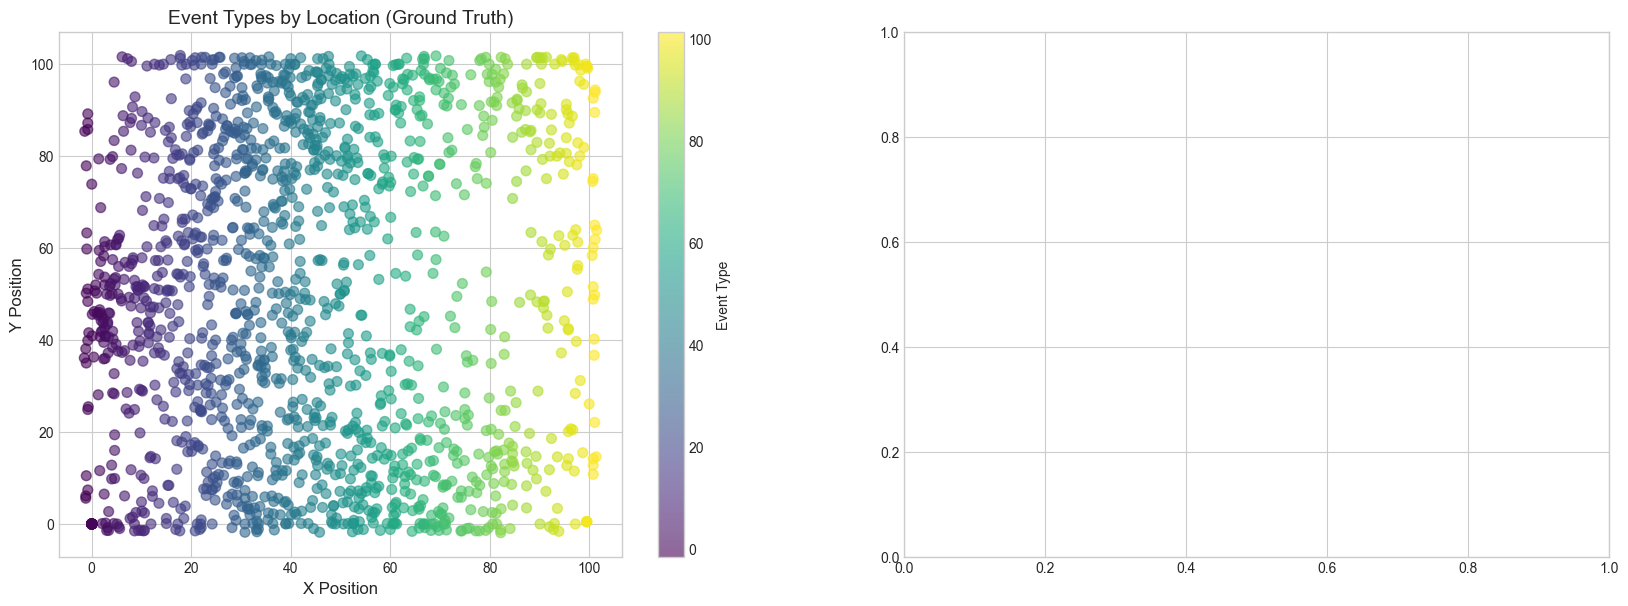

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.decomposition import PCA

# Set figure aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.figure(figsize=(20, 15))

# Plot 1: Scatter plot of spatial coordinates colored by actual event_name
plt.subplot(2, 2, 1)
unique_events = np.unique(y)
cmap = plt.cm.get_cmap('viridis', len(unique_events))

scatter = plt.scatter(X['x'], X['y'], c=y, cmap=cmap, alpha=0.6, s=50)
plt.title('Event Types by Location (Ground Truth)', fontsize=14)
plt.xlabel('X Position', fontsize=12)
plt.ylabel('Y Position', fontsize=12)
plt.colorbar(scatter, label='Event Type')

# Plot 2: KNN decision boundaries using PCA (to visualize high-dimensional data)
plt.subplot(2, 2, 2)

# Apply PCA to visualize the decision boundaries
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create a mesh grid for decision boundary visualization
h = 0.02  # step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Train a KNN model on the PCA-transformed data
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_pca, y_train)

# Predict on the mesh grid
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

# Plot the training points
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolor='k', cmap=cmap, alpha=0.8)
plt.title('KNN Decision Boundaries (PCA-reduced)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.colorbar(scatter, label='Event Type')

# Plot 3: Confusion Matrix
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_events[:10], yticklabels=unique_events[:10])
plt.title('Confusion Matrix (Top 10 Event Types)', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)

# Plot 4: K-value optimization
plt.subplot(2, 2, 4)
k_range = range(1, 20, 2)
scores = []

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    scores.append(knn_model.score(X_test_scaled, y_test))

plt.plot(k_range, scores, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
plt.title('KNN Performance by K Value', fontsize=14)
plt.xlabel('Number of Neighbors (K)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)

# Add vertical line at k=5
plt.axvline(x=5, color='red', linestyle='--', label='Current k=5')
plt.legend()

plt.tight_layout()
plt.show()

# Display model performance metrics
print("\nModel Performance Summary:")
print(f"Accuracy: {knn.score(X_test_scaled, y_test):.4f}")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")